In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from statsmodels.graphics.gofplots import ProbPlot


## Helper functions!

In [21]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [22]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [23]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday_DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_temp['Downtown_NotWeekday_Center'] = X['Downtown'] * (1 - X['Weekday'] ) * X['Center']
X_temp["Shops_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['Shops'] 

X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday_DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,0,0,974,10,1,1,0,0
2,0,0,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,0,0,958,9,1,1,0,1
4,0,0,0,0,0,0,0,103,4,0,1,0,1


## Pre Process the data ad Build the Model
 

In [24]:
# Build and execute model
formula = "Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_DT + Weekday_DT + Center_DT + Shops_DWC" 
train = pd.concat([X_new, y], axis = 1)
model = ols(formula, data=train).fit()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.108e+06
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:55:14   Log-Likelihood:                -16857.
No. Observations:               22000   AIC:                         3.374e+04
Df Residuals:                   21989   BIC:                         3.382e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.8478      0.128    147.204      0.000      18.597      19.099
Shops          0.0182      0.001     14.325      0.000       0.016       0.021
ATMs          -1.0002      0.002   -508.916      0.000      -1.004      -0.996
Downtown     -47.8601      0.244   -196.119      0.000     -48.338     -47.382
Weekday       -2.2209      0.014   -157.390      0.000      -2.249      -2.193
Center         3.5883      0.021    169.201      0.000       3.547       3.630
High           0.9982      0.008    130.464      0.000       0.983       1.013
Shops_DT       0.0918      0.001     71.130      0.000       0.089       0.094
Weekday_DT     0.2247      0.017     13.065      0.000       0.191       0.258
Center_DT     -0.5838      0.027    -21.792      0.000      -0.636      -0.531
Shops_DWC      0.0200   3.06e-05    653.222      0.000       0.020       0.020
==============================================================================
Omnibus:                       79.112   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.711
Skew:                           0.114   Prob(JB):                     2.44e-19
Kurtosis:                       3.204   Cond. No.                     8.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
robust_model = model.get_robustcov_results(cov_type='HC0')
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.235e+06
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:55:14   Log-Likelihood:                -16857.
No. Observations:               22000   AIC:                         3.374e+04
Df Residuals:                   21989   BIC:                         3.382e+04
Df Model:                          10                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.8478      0.142    132.512      0.000      18.569      19.127
Shops          0.0182      0.001     12.876      0.000       0.015       0.021
ATMs          -1.0002      0.002   -529.753      0.000      -1.004      -0.996
Downtown     -47.8601      0.246   -194.508      0.000     -48.342     -47.378
Weekday       -2.2209      0.017   -132.550      0.000      -2.254      -2.188
Center         3.5883      0.037     96.541      0.000       3.515       3.661
High           0.9982      0.008    130.094      0.000       0.983       1.013
Shops_DT       0.0918      0.001     64.137      0.000       0.089       0.095
Weekday_DT     0.2247      0.019     11.693      0.000       0.187       0.262
Center_DT     -0.5838      0.040    -14.556      0.000      -0.662      -0.505
Shops_DWC      0.0200   2.74e-05    727.341      0.000       0.020       0.020
==============================================================================
Omnibus:                       79.112   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.711
Skew:                           0.114   Prob(JB):                     2.44e-19
Kurtosis:                       3.204   Cond. No.                     8.61e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# model values
model_fitted_y = model.fittedvalues

# model residuals
model_residuals = model.resid

# normalized residuals 
model_norm_residuals = model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

Text(0, 0.5, 'Residuals')

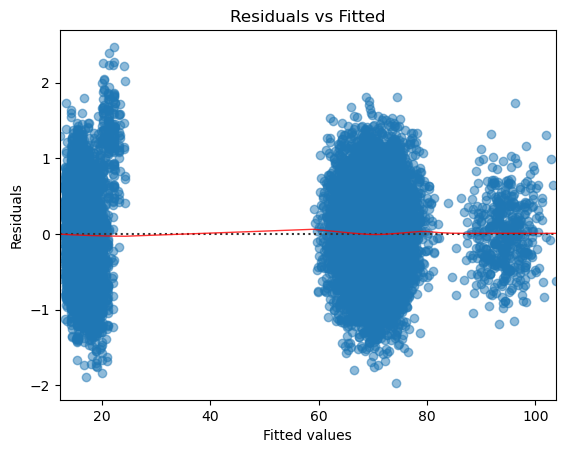

In [28]:
plot_lm = plt.figure()
plot_lm.axes[0] = sns.residplot(x=model_fitted_y, 
                               y='Withdraw',
                               data=train,
                               lowess=True,
                               scatter_kws={'alpha': 0.5},
                               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm.axes[0].set_title('Residuals vs Fitted')
plot_lm.axes[0].set_xlabel('Fitted values')
plot_lm.axes[0].set_ylabel('Residuals') 

c:\Users\eReuse\anaconda3\Lib\site-packages\statsmodels\graphics\gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


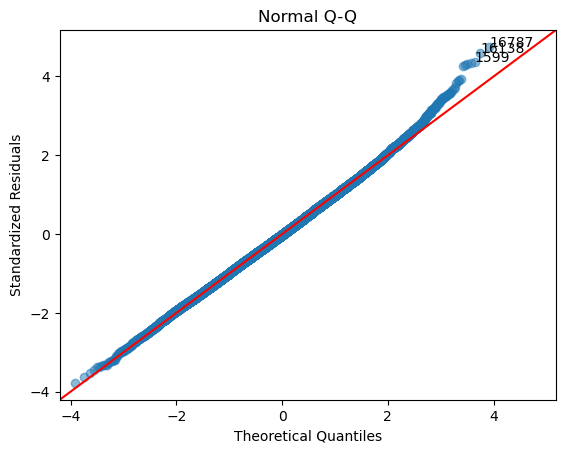

In [29]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));